In [1]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt

import keras

from keras.models import Sequential
from keras.layers import Dense
from keras.optimizers import Adam

from keras.utils.np_utils import to_categorical
from keras.layers import Dropout, Flatten
from keras.layers.convolutional import Conv2D, MaxPooling2D
from keras.preprocessing.image import ImageDataGenerator


import pickle
import random

import cv2
import requests
from PIL import Image

Using TensorFlow backend.


In [2]:
np.random.seed(0)

In [3]:
train_file_name = 'train.p'
test_file_name = 'test.p'
val_file_name = 'valid.p'


with open(train_file_name, 'rb') as train_file, open(test_file_name, 'rb') as test_file, open(val_file_name, 'rb') as val_file:
    train_data = pickle.load(train_file)
    test_data = pickle.load(test_file)
    valid_data = pickle.load(val_file)

In [4]:
print(type(train_data))
print(type(test_data))
print(type(valid_data))

<class 'dict'>
<class 'dict'>
<class 'dict'>


In [5]:
X_train, y_train = train_data['features'], train_data['labels']
X_valid, y_valid = valid_data['features'], valid_data['labels']
X_test, y_test = test_data['features'], test_data['labels']

In [6]:
print(X_train.shape)
print(X_valid.shape)
print(X_test.shape)

(34799, 32, 32, 3)
(4410, 32, 32, 3)
(12630, 32, 32, 3)


In [7]:
print(y_train.shape)
print(y_valid.shape)
print(y_test.shape)

(34799,)
(4410,)
(12630,)


In [8]:
data = pd.read_csv("signnames.csv")
print(data)

    ClassId                                           SignName
0         0                               Speed limit (20km/h)
1         1                               Speed limit (30km/h)
2         2                               Speed limit (50km/h)
3         3                               Speed limit (60km/h)
4         4                               Speed limit (70km/h)
5         5                               Speed limit (80km/h)
6         6                        End of speed limit (80km/h)
7         7                              Speed limit (100km/h)
8         8                              Speed limit (120km/h)
9         9                                         No passing
10       10       No passing for vechiles over 3.5 metric tons
11       11              Right-of-way at the next intersection
12       12                                      Priority road
13       13                                              Yield
14       14                                            

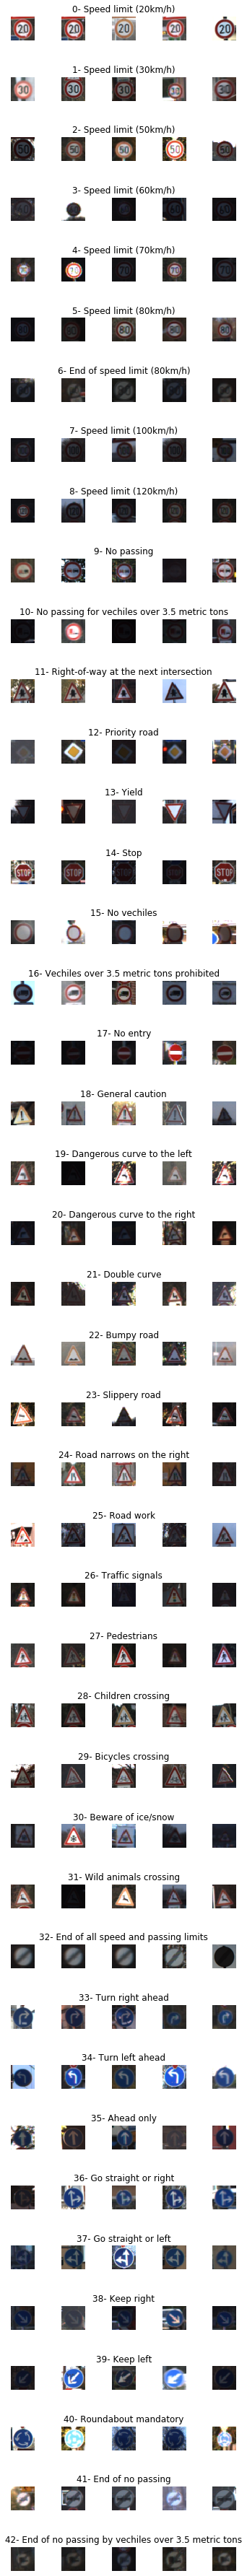

In [9]:
number_of_sample = []

cols = 5
rows = 43

fig, axs = plt.subplots(nrows = rows, ncols = cols, figsize = (5, 50))
fig.tight_layout()

for i in range(cols):
    for j, row in data.iterrows():
        x_select = X_train[y_train == j]
        axs[j][i].imshow(
            x_select[random.randint(0, len(x_select) - 1), :, :], 
            cmap = plt.get_cmap("gray"))
        axs[j][i].axis("off")
        if i == 2:
            axs[j][i].set_title(str(j) + '- ' + row['SignName'])
            number_of_sample.append(len(x_select))

[180, 1980, 2010, 1260, 1770, 1650, 360, 1290, 1260, 1320, 1800, 1170, 1890, 1920, 690, 540, 360, 990, 1080, 180, 300, 270, 330, 450, 240, 1350, 540, 210, 480, 240, 390, 690, 210, 599, 360, 1080, 330, 180, 1860, 270, 300, 210, 210]


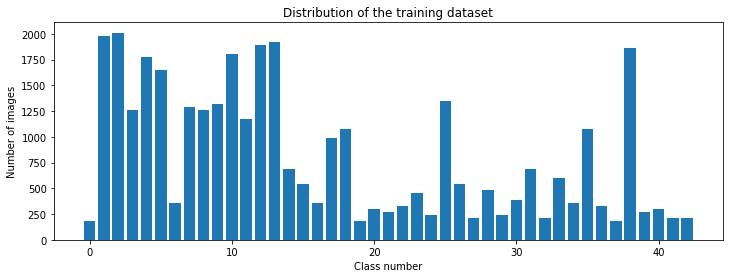

In [10]:
print(number_of_sample)
plt.figure(figsize=(12, 4))
plt.bar(range(0, rows), number_of_sample)
plt.title("Distribution of the training dataset")
plt.xlabel("Class number")
plt.ylabel("Number of images")
plt.show()

In [11]:
plt.rcParams['image.cmap'] = 'gray'
def plot_img(img):
    plt.imshow(img)
    plt.show()
    print(img.shape)

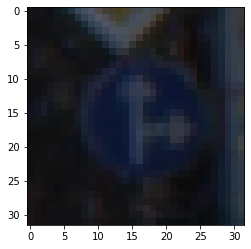

(32, 32, 3)
36


In [12]:
plot_img(X_train[1000])

print(y_train[1000])

In [13]:
def gray_scale(img):
    return cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

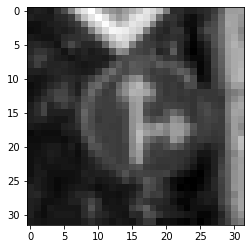

(32, 32)


In [14]:
img = gray_scale(X_train[1000])
plot_img(img)

In [15]:
def equalize(img):
    return cv2.equalizeHist(img)

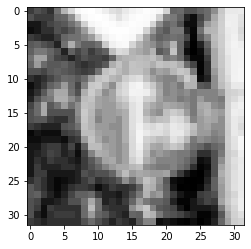

(32, 32)


In [16]:
plot_img(equalize(img))

In [17]:
def preprocessing(img):
    return equalize(gray_scale(img)) / 255

In [18]:
X_train = np.array(list(map(preprocessing, X_train)))
X_valid = np.array(list(map(preprocessing, X_valid)))
X_test = np.array(list(map(preprocessing, X_test)))

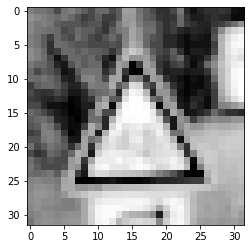

(32, 32)


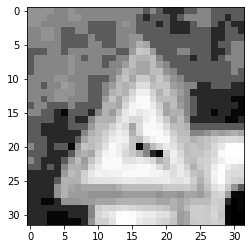

(32, 32)


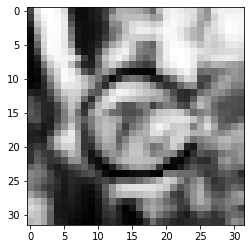

(32, 32)


In [19]:
plot_img(X_train[random.randint(0, len(X_train) - 1)])
plot_img(X_valid[random.randint(0, len(X_valid) - 1)])
plot_img(X_test[random.randint(0, len(X_test) - 1)])

In [20]:
X_train = X_train.reshape(34799, 32, 32, 1)
X_valid = X_valid.reshape(4410, 32, 32, 1)
X_test = X_test.reshape(12630, 32, 32, 1)

In [21]:
print(X_train.shape)
print(X_valid.shape)
print(X_test.shape)

(34799, 32, 32, 1)
(4410, 32, 32, 1)
(12630, 32, 32, 1)


In [22]:
image_data_generator = ImageDataGenerator(
    width_shift_range = 0.2,
    height_shift_range = 0.2,
    zoom_range = 0.4,
    shear_range = 0.2,
    rotation_range = 10
)

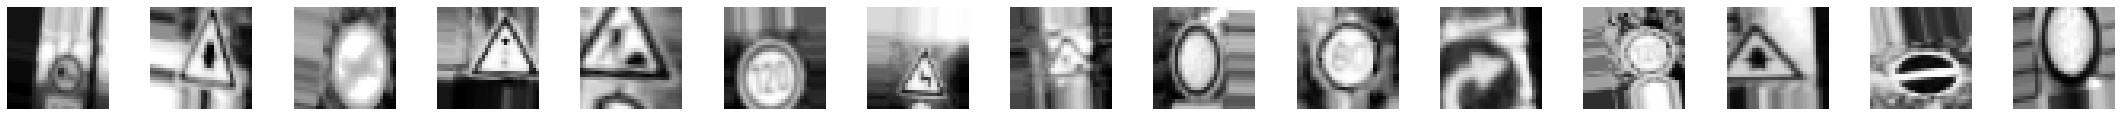

In [23]:
image_data_generator.fit(X_train)

batches = image_data_generator.flow(X_train, y_train, batch_size = 20)

X_batch, y_batch = next(batches)

fig, axs = plt.subplots(1, 15, figsize = (30, 10))
fig.tight_layout()

for i in range(15):
    axs[i].imshow(X_batch[i].reshape(32, 32))
    axs[i].axis('off')

In [24]:
y_train = to_categorical(y_train, rows)
y_test = to_categorical(y_test, rows)
y_valid = to_categorical(y_valid, rows)

In [25]:
def leNet_model():
    model = Sequential()
    model.add(Conv2D(60, (5, 5), 
                     input_shape = (32, 32, 1), 
                     activation = 'relu'))
    model.add(Conv2D(60, (5, 5), activation = 'relu'))
    model.add(MaxPooling2D(pool_size = (2, 2), ))

    model.add(Conv2D(30,(3, 3), activation = 'relu' ))
    model.add(Conv2D(30,(3, 3), activation = 'relu' ))
    model.add(MaxPooling2D(pool_size = (2, 2)))
    model.add(Dropout(0.5))
    
    model.add(Flatten())
    model.add(Dense(500, activation = 'relu'))
    model.add(Dropout(0.5))
    model.add(Dense(rows, activation = 'softmax'))
    
    model.compile(Adam(lr = 0.001), 
                  loss = 'categorical_crossentropy', 
                  metrics = ['accuracy'])
    return model

In [26]:
model = leNet_model()

print(model.summary())

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 28, 28, 60)        1560      
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 24, 24, 60)        90060     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 12, 12, 60)        0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 10, 10, 30)        16230     
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 8, 8, 30)          8130      
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 4, 4, 30)          0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 4, 4, 30)         

In [27]:
history = model.fit_generator(
    image_data_generator.flow(X_train, y_train, batch_size = 50),
    steps_per_epoch = 2000, 
    epochs = 10,
    validation_data = (X_valid, y_valid),
    verbose = 1,
    shuffle = 1)

Epoch 1/10
2000/2000 [==============================] - 295s 147ms/step - loss: 2.1185 - accuracy: 0.3769 - val_loss: 0.4737 - val_accuracy: 0.8492
Epoch 2/10
2000/2000 [==============================] - 298s 149ms/step - loss: 0.9322 - accuracy: 0.7072 - val_loss: 0.2038 - val_accuracy: 0.9349
Epoch 3/10
2000/2000 [==============================] - 3931s 2s/step - loss: 0.6387 - accuracy: 0.8008 - val_loss: 0.1643 - val_accuracy: 0.9469
Epoch 4/10
2000/2000 [==============================] - 312s 156ms/step - loss: 0.5197 - accuracy: 0.8396 - val_loss: 0.1099 - val_accuracy: 0.9705
Epoch 5/10
2000/2000 [==============================] - 993s 497ms/step - loss: 0.4547 - accuracy: 0.8596 - val_loss: 0.1284 - val_accuracy: 0.9683
Epoch 6/10
2000/2000 [==============================] - 288s 144ms/step - loss: 0.4170 - accuracy: 0.8724 - val_loss: 0.0649 - val_accuracy: 0.9825
Epoch 7/10
2000/2000 [==============================] - 294s 147ms/step - loss: 0.3806 - accuracy: 0.8847 - val_lo

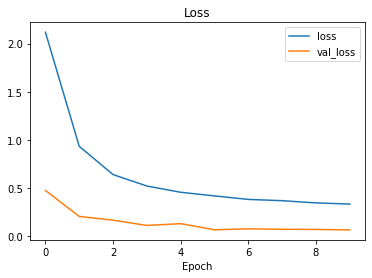

In [28]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title("Loss")
plt.legend(['loss', 'val_loss'])
plt.xlabel("Epoch")
plt.show()

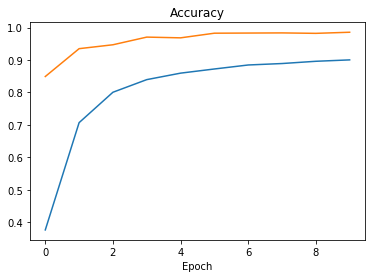

In [29]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title("Accuracy")
plt.xlabel("Epoch")
plt.show()

In [30]:
score = model.evaluate(X_test, y_test)

12630/12630 [==============================] - 10s 821us/step


In [31]:
print('Test score', np.round(score[0], 4))
print('Test accuracy', np.round(score[1], 4))

Test score 0.1651
Test accuracy 0.9572


In [32]:
#fetch image
def fetch_image(url):
    r = requests.get(url, stream=True)
    img = Image.open(r.raw)
    plt.imshow(img, cmap=plt.get_cmap('gray'))
    plt.show()
    return img

In [33]:
def preprocess_image(img):
    img = np.asarray(img)
    img = cv2.resize(img, (32, 32))
    img = preprocessing(img)
    return img.reshape(1, 32, 32, 1)

In [34]:
def test_image(url):
    img = fetch_image(url)
    img = preprocess_image(img)
    result = model.predict_classes(img).tolist()[0]
    print("This is: "+ data[data.ClassId == result].SignName.tolist()[0])

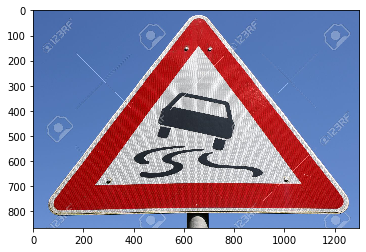

This is: Slippery road


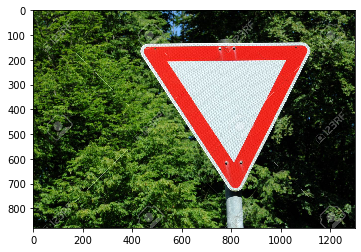

This is: Yield


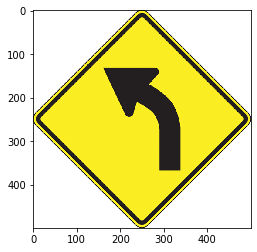

This is: Turn left ahead


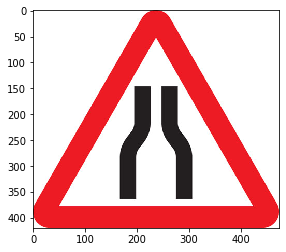

This is: Road narrows on the right


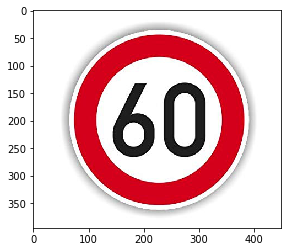

This is: Speed limit (60km/h)


In [46]:
test_image('https://previews.123rf.com/images/bwylezich/bwylezich1608/bwylezich160800375/64914157-german-road-sign-slippery-road.jpg')

test_image('https://previews.123rf.com/images/pejo/pejo0907/pejo090700003/5155701-german-traffic-sign-no-205-give-way.jpg')

test_image('https://www.tenaquip.com/images/large/s/sej256.jpg?1538429814')

test_image('https://assets.digital.cabinet-office.gov.uk/media/55b75f15ed915d07fe000007/warning-sign-road-narrow-both-sides.jpg')

test_image('https://images-na.ssl-images-amazon.com/images/I/41ZLLSOrReL._SX450_.jpg')

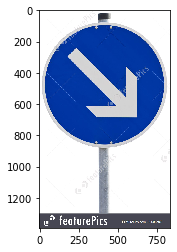

This is: Keep right


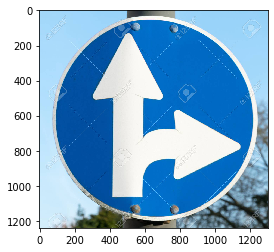

This is: Go straight or right


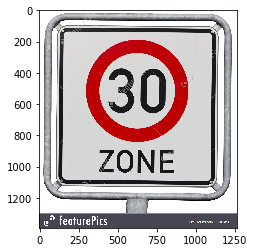

This is: Speed limit (30km/h)


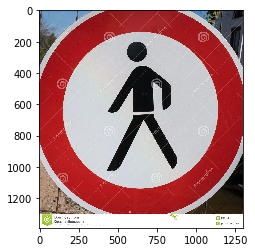

This is: Traffic signals


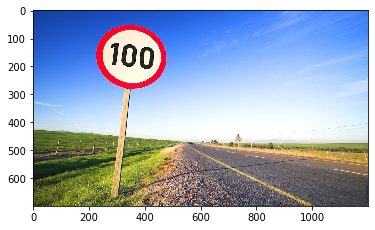

This is: End of no passing by vechiles over 3.5 metric tons


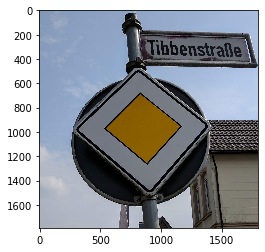

This is: Priority road


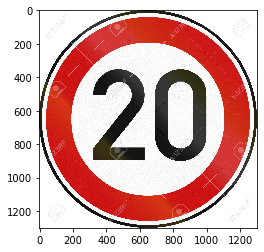

This is: Speed limit (20km/h)


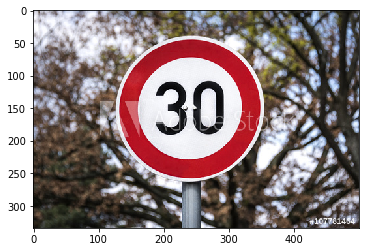

This is: Speed limit (20km/h)


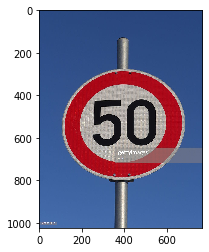

This is: Speed limit (50km/h)


In [49]:
test_image('https://www.featurepics.com/StockImage/20110915/traffic-sign-stock-picture-1998697.jpg')
test_image('https://previews.123rf.com/images/scipio2012/scipio20121703/scipio2012170300067/75874522-german-traffic-sign.jpg')
test_image('https://www.featurepics.com/StockImage/20110915/german-traffic-sign-stock-image-1998460.jpg')
test_image('https://thumbs.dreamstime.com/z/german-traffic-sign-pedestrian-area-germany-89397828.jpg')
test_image('https://miro.medium.com/max/2400/1*PoVAzAk7lTiWXHIgm2dLeQ.jpeg')
test_image('https://angelikasgerman.co.uk/wp-content/uploads/2018/02/Priority.jpg')
test_image('https://previews.123rf.com/images/jojoo64/jojoo641502/jojoo64150200027/36476396-german-traffic-sign-restricting-speed-to-20-kilometers-per-hour-.jpg')
test_image('https://as1.ftcdn.net/jpg/01/07/78/14/500_F_107781464_C9qRqftFgoke7Nbpzzm0kGjBPkh6J4eM.jpg')
test_image('https://media.gettyimages.com/photos/german-traffic-signs-picture-id459381113')

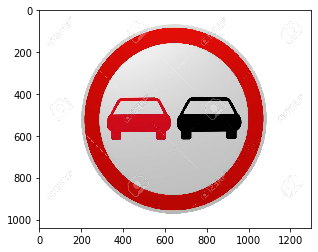

This is: No passing


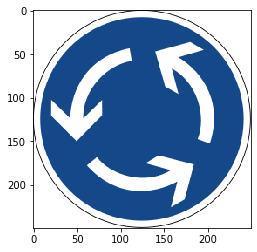

This is: Roundabout mandatory


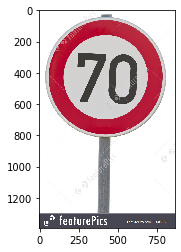

This is: Speed limit (70km/h)


In [51]:
test_image('https://previews.123rf.com/images/bubbleundcoon/bubbleundcoon1807/bubbleundcoon180700055/104983303-german-traffic-sign-no-passing-front-view-2d-rendering.jpg')
test_image('https://www.rhinocarhire.com/CorporateSite/media/Drive-Smart/Road-Signs/Priority-Signs/Germany-Priority-Sign-Mandatory-direction-of-the-roundabout.png')
test_image('https://www.featurepics.com/StockImage/20110915/speed-limit-sign-stock-picture-1998817.jpg')